In [1]:
%matplotlib inline

import torch

from torch.autograd import Variable
from torch.nn.init import xavier_normal

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [2]:
BATCH_SIZE = 64

transform = transforms.ToTensor()

# Load and transform data
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [45]:
class StackedAutoEncoder(nn.Module):
    """
    Stacked Auto Encoder With Tied Weights
    """
    def __init__(self, input_size, hidden_size=300, coding_size=150):
        super(StackedAutoEncoder, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, coding_size)
        self.dropout = nn.Dropout(p=0.3)
        self.sigmoid = nn.Sigmoid()
        
    def kl_divergence(self, p, q): 
        return p*torch.log(p/q)+(1-p)*torch.log((1-p)/(1-q))
        
    def forward(self, x):
        hidden1_output = F.elu(self.hidden1(x))
        hidden2_output = self.sigmoid(self.hidden2(hidden1_output))
        hidden3_output = F.elu(F.linear(hidden2_output,
                                       weight=self.hidden2.weight.transpose(0,1)))
        output = F.linear(hidden3_output, weight=self.hidden1.weight.transpose(0,1))
        return output, torch.mean(hidden2_output, dim=0)

In [46]:
sae = StackedAutoEncoder(input_size=28*28)

In [47]:
criterion = nn.MSELoss()
optimizer = optim.Adam(sae.parameters())

In [48]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [59]:
N_EPOCHS = 10
total_loss = 0
print_every = 20000 // BATCH_SIZE
plot_every = 1000 // BATCH_SIZE
all_losses = []
sparsity_target = 0.1
sparsity_weight = 100
iter = 1

start = time.time()

for e in range(N_EPOCHS):
    for i_batch, batch in enumerate(trainloader):
        image = batch[0]
        label = batch[1]
        image = Variable(image.view(-1, 1, 28*28))
        
        sae.zero_grad()
        output, coding = sae(image)
        sparsity = torch.sum(sae.kl_divergence(sparsity_target, coding))
        loss = criterion(output, image) + sparsity_weight * sparsity
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
        
        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / (len(trainloader) * N_EPOCHS) * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        iter = iter + 1

0m 2s (312 3%) 5.3467
0m 4s (624 6%) 3.3219
0m 6s (936 9%) 2.9262
0m 8s (1248 13%) 1.3905
0m 11s (1560 16%) 1.0633
0m 13s (1872 19%) 0.6970
0m 16s (2184 23%) 0.7743
0m 18s (2496 26%) 0.8816
0m 21s (2808 29%) 2.3691
0m 23s (3120 33%) 0.4395
0m 25s (3432 36%) 0.3318
0m 28s (3744 39%) 1.7241
0m 30s (4056 43%) 0.7907
0m 33s (4368 46%) 0.7017
0m 35s (4680 49%) 0.3017
0m 38s (4992 53%) 0.3146
0m 40s (5304 56%) 0.5094
0m 42s (5616 59%) 0.2891
0m 45s (5928 63%) 0.4550
0m 47s (6240 66%) 0.1931
0m 50s (6552 69%) 0.2951
0m 52s (6864 73%) 0.1792
0m 55s (7176 76%) 0.2283
0m 57s (7488 79%) 0.3160
1m 0s (7800 83%) 0.4096
1m 2s (8112 86%) 0.1480
1m 5s (8424 89%) 0.2195
1m 7s (8736 93%) 0.1846
1m 10s (9048 96%) 0.3247
1m 12s (9360 99%) 2.1601


In [60]:
print(sparsity)

Variable containing:
1.00000e-03 *
  9.8246
[torch.FloatTensor of size 1]



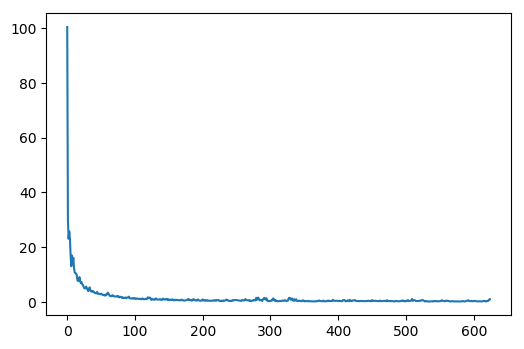

In [61]:
plt.plot(all_losses)

In [62]:
n = 1
for i, batch in enumerate(testloader):
    if i >= n:
        break
    image = batch[0]
    label = batch[1]
    image = Variable(image.view(-1, 1, 28*28))
    output, coding = sae(image)
    outputs = output.data.cpu().numpy()

Text(0.5,1,'Actual')

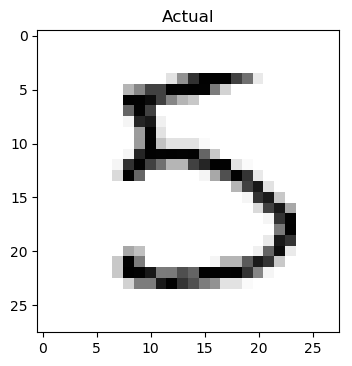

In [63]:
index = 15
plt.imshow(image[index].data.cpu().numpy().reshape(28,28),
          cmap="Greys", interpolation="nearest")
plt.title("Actual")

Text(0.5,1,'Reconstructed')

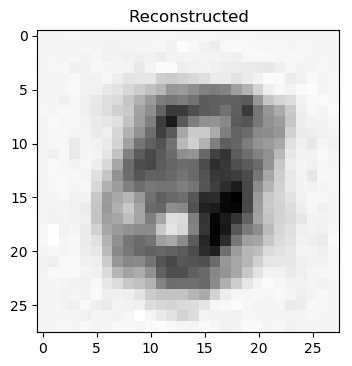

In [64]:
plt.imshow(outputs[index].reshape(28,28),cmap="Greys")
plt.title("Reconstructed")

## Visualizing Features

In [65]:
hidden1_weights = sae.hidden1.weight.data.cpu().numpy()

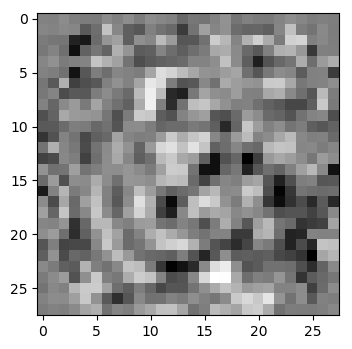

In [69]:
neuron = 115
plt.imshow(hidden1_weights[neuron].reshape([28,28]),
           cmap='Greys')